<a href="https://colab.research.google.com/github/VladislavKlekovkin/s1mulation/blob/master/1_cross_entropy_method_snake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# for render
%%bash
# install required system dependencies
apt-get install -y xvfb x11-utils
# install required python dependencies
pip install gym[box2d]==0.17.* \
            pyvirtualdisplay==0.2.* \
            PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 11 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,977 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.7 [783 kB]
Fetched 993 kB in 1s (883 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 144628 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.4-1) ...
Sel

In [ ]:
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [ ]:
!git clone https://github.com/nicomon24/Sneks.git

import sys
sys.path.append('./Sneks')
from sneks.envs.snek import SingleSnek

import gym
env_dict = gym.envs.registration.registry.env_specs.copy()
for env in env_dict:
     if 'snek-raw-16-v1' in env:
          print('Remove {} from registry'.format(env))
          del gym.envs.registration.registry.env_specs[env]

class SingleSnekList(SingleSnek):
    def _get_state(self):
        res = SingleSnek._get_state(self)
        return np.reshape(res, np.multiply(*res.shape), order='A')

Cloning into 'Sneks'...
remote: Enumerating objects: 301, done.
remote: Total 301 (delta 0), reused 0 (delta 0), pack-reused 301
Receiving objects: 100% (301/301), 223.80 KiB | 11.19 MiB/s, done.
Resolving deltas: 100% (126/126), done.
Remove snek-raw-16-v1 from registry
Remove hungrysnek-raw-16-v1 from registry
Remove babysnek-raw-16-v1 from registry


In [ ]:
from collections import namedtuple
import numpy as np
from torch.utils.tensorboard import SummaryWriter


import torch
import torch.nn as nn
from torch import optim

WIDTH = 16
HEIGHT = 16

HIDDEN_SIZE = 128
BATCH_SIZE = 2048
PERCENTILE = 99.9


class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)


Episode = namedtuple('Episode', field_names=['reward', 'steps'])
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])


def iterate_batches(env, net, batch_size):
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs = env.reset()
    sm = nn.Softmax(dim=1)
    while True:
        obs_v = torch.FloatTensor([obs])
        act_probs_v = sm(net(obs_v))
        act_probs = act_probs_v.data.numpy()[0]
        action = np.random.choice(len(act_probs), p=act_probs)
        next_obs, reward, is_done, _ = env.step(action)
        episode_reward += reward
        episode_steps.append(EpisodeStep(observation=obs, action=action))
        if is_done:
            batch.append(Episode(reward=episode_reward, steps=episode_steps))
            episode_reward = 0.0
            episode_steps = []
            next_obs = env.reset()
            if len(batch) == batch_size:
                yield batch
                batch = []
        obs = next_obs

def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s.reward, batch))
    reward_bound = np.percentile(rewards, percentile)
    reward_mean = float(np.mean(rewards))

    train_obs = []
    train_act = []
    elite_batch = []
    #total_episodes = 0
    #top_episode_rewards = []

    for example in batch:
        if example.reward < reward_bound:
            continue
        train_obs.extend(map(lambda step: step.observation, example.steps))
        train_act.extend(map(lambda step: step.action, example.steps))
        elite_batch.append()
        #total_episodes += 1
        #top_episode_rewards.append(example.reward)

    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.LongTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean, #total_episodes, np.mean(top_episode_rewards)

In [ ]:
env = SingleSnekList(obs_type='raw', n_food=1)
# env = gym.wrappers.Monitor(env, directory="mon", force=True)
obs_size = env.SIZE[0] *env.SIZE[1]
n_actions = env.action_space.n

net = Net(obs_size, HIDDEN_SIZE, n_actions)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.01)
writer = SummaryWriter(comment="-Snake")

for iter_no, batch in enumerate(iterate_batches(env, net, BATCH_SIZE)):
    obs_v, acts_v, reward_b, reward_m, total_eps, top_rewards = filter_batch(batch, PERCENTILE)
    print(total_eps, top_rewards)
    optimizer.zero_grad()
    action_scores_v = net(obs_v)
    loss_v = objective(action_scores_v, acts_v)
    loss_v.backward()
    optimizer.step()
    if iter_no % 1 == 0:
        print("%d: loss=%.3f, reward_mean=%.1f, reward_bound=%.1f" % (
            iter_no, loss_v.item(), reward_m, reward_b))
    writer.add_scalar("loss", loss_v.item(), iter_no)
    writer.add_scalar("reward_bound", reward_b, iter_no)
    writer.add_scalar("reward_mean", reward_m, iter_no)
    if reward_m > 20:
        print("Solved!")
        break
writer.close()

63 0.015873015873015872
5210: loss=0.000, reward_mean=-1.0, reward_bound=0.0


KeyboardInterrupt: ignored

In [ ]:
def render(obs):
    for ind, elem in enumerate(obs):
      print(elem, end=' ')
      if ind % 16 == 0:
        print()

In [ ]:
env = SingleSnekList(obs_type='raw', n_food=1)

In [ ]:
obs = env.reset()
render(obs)

0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 101.0 100.0 100.0 100.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 64.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0

In [ ]:
obs, reward, done, _ = env.step(1)
render(obs)
print('\nraward:', reward)

0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 64.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0

Observation: (16, 16, 3)


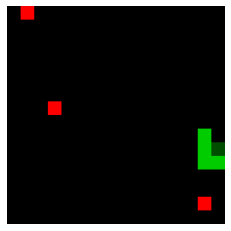

In [ ]:
from time import sleep
import matplotlib.pyplot as plt
from IPython import display

_, ax = plt.subplots(1, 1)

for e in range(1):
    obs = env.reset()
    img = ax.imshow(env.render(mode='rgb_array'))
    print(obs.shape)
    done = False
    r = 0
    while not done:
        action = env.action_space.sample()

        img.set_data(env.render(mode='rgb_array')) 
        ax.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)

        obs, reward, done, info = env.step(action)
        r += reward
        #env.render(mode='rgb_array')
        sleep(1)

print("Observation:", obs.shape)
env.close()